In [6]:
import glob
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots

# Set the plot style
plt.style.use(["science", "nature"])
DPI = 600
FIGSIZE = (6, 4)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Directories
CURRENT_DIR = os.getcwd()
PLOTS_DIR = Path(CURRENT_DIR) / "images"
os.makedirs(PLOTS_DIR, exist_ok=True)

# TXT files to plot
FOLDER_TO_PLOT = Path(CURRENT_DIR) / "I.17 Results"
files = [FOLDER_TO_PLOT / f for f in os.listdir(FOLDER_TO_PLOT) if "A100" in f and "r16" in f]

print("Plotting the following files:")
for f in files:
    print(f)

Plotting the following files:
/home/camilo/Repositorios/generative-ai/project/project_part2/I.17 Results/Phi-3-SFT-Repair-r16-alpha32-on-Combined-finetuning-A100.txt
/home/camilo/Repositorios/generative-ai/project/project_part2/I.17 Results/Phi-3-SFT-Repair-r16-alpha32-on-Repair-finetuning-A100.txt
/home/camilo/Repositorios/generative-ai/project/project_part2/I.17 Results/Phi-3-SFT-Hints-r16-alpha32-on-Hint-finetuning-A100.txt


In [7]:
def extract_parameters_from_filename(filename: str) -> tuple[int, int, str]:
    """Extract r and alpha values from filename."""
    if "combined" in filename.lower():
        dataset = "combined"
    elif "repair" in filename.lower():
        dataset = "repair"
    elif "hint" in filename.lower():
        dataset = "hint"

    pattern = r"r(\d+)-alpha(\d+)"
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1)), int(match.group(2)), dataset
    return None, None, None


def parse_loss_values(file_content):
    """Extract loss values from log content."""
    losses = []
    pattern = r"'loss': (\d+\.\d+)"
    matches = re.finditer(pattern, file_content)
    for match in matches:
        losses.append(float(match.group(1)))
    return losses


def extract_training_metrics(file_content):
    """Extract training runtime and memory usage."""
    runtime_pattern = r"Training runtime: (\d+\.\d+) minutes"
    memory_pattern = r"Training memory: (\d+\.\d+) GB"
    params_pattern = r"Number of trainable parameters = ([\d,]+)"

    runtime_match = re.search(runtime_pattern, file_content)
    memory_match = re.search(memory_pattern, file_content)
    params_match = re.search(params_pattern, file_content)

    runtime = float(runtime_match.group(1)) if runtime_match else None
    memory = float(memory_match.group(1)) if memory_match else None
    params = int(params_match.group(1).replace(",", "")) if params_match else None

    return runtime, memory, params


def process_log_files(filepaths: list[str]):
    """Process all log files and return structured data."""
    data = []
    metrics_data = []

    for filename in filepaths:
        with open(filename, "r") as f:
            content = f.read()

        print(f"Processing {os.path.basename(filename)}... ", end="")
        r_value, alpha_value, dataset = extract_parameters_from_filename(os.path.basename(filename))
        print(f"r={r_value}, alpha={alpha_value}, dataset={dataset}")

        losses = parse_loss_values(content)
        runtime, memory, params = extract_training_metrics(content)

        # Store loss values
        if dataset == "combined":
            additional_str = " (m)"
        elif dataset == "repair":
            additional_str = " (r)"
        elif dataset == "hint":
            additional_str = " (h)"

        for epoch_idx, loss in enumerate(losses):
            data.append(
                {
                    "r_value": r_value,
                    "alpha_value": alpha_value,
                    "epoch": epoch_idx / len(losses),
                    "loss": loss,
                    "dataset": dataset,
                    "config": f"({r_value}, {alpha_value})" + additional_str,
                }
            )

        # Store metrics
        metrics_data.append(
            {
                "r_value": r_value,
                "alpha_value": alpha_value,
                "runtime": runtime,
                "memory": memory,
                "params": params,
                "dataset": dataset,
                "config": f"({r_value}, {alpha_value})" + additional_str,
            }
        )

    # Sort data by r and alpha values
    loss_df = pd.DataFrame(data)
    metrics_df = pd.DataFrame(metrics_data)
    loss_df = loss_df.sort_values(by=["r_value", "alpha_value", "dataset", "epoch"])
    metrics_df = metrics_df.sort_values(by=["r_value", "alpha_value", "dataset"])

    return loss_df, metrics_df


def plot_loss_results(
    loss_df: pd.DataFrame, figsize: tuple[int, int] = (4, 2), filepath: Path | str | None = None, dpi=DPI
) -> None:
    """Create separate plots for loss curves and training metrics."""
    # Plot loss curves
    fig_loss = plt.figure(figsize=figsize, dpi=dpi)
    ax_loss = fig_loss.add_subplot(111)

    configs = loss_df["config"].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(configs)))

    for config, color in zip(configs, colors):
        mask = loss_df["config"] == config
        ax_loss.plot(
            loss_df[mask]["epoch"] * 100,
            loss_df[mask]["loss"],
            "o-",
            label=config,
            color=color,
            markersize=4,
            linewidth=2,
        )

    # ax_loss.set_title("Training Loss vs Epoch")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend(title="Configuration")
    fig_loss.tight_layout()

    if filepath:
        filepath = str(filepath)
        fig_loss.savefig(filepath, dpi=dpi, format=filepath.split(".")[-1], bbox_inches="tight")

    plt.show()
    plt.close(fig_loss)


def plot_metrics(
    metrics_df: pd.DataFrame,
    figsize: tuple[int, int] = (4, 2),
    ylim: tuple[float, float] | None = None,
    filepath: Path | str | None = None,
    dpi=DPI,
) -> None:
    """Create a bar plot for training metrics."""
    fig_metrics = plt.figure(figsize=figsize, dpi=dpi)
    ax_metrics = fig_metrics.add_subplot(111)

    x = np.arange(len(metrics_df["config"]))
    width = 0.3  # width of the bars

    # Plot runtime bars
    rects1 = ax_metrics.bar(x - width, metrics_df["runtime"], width, label="Runtime (minutes)")

    # Plot memory bars
    rects2 = ax_metrics.bar(x, metrics_df["memory"] * 10, width, label="Memory $\\times 10^1 (\\text{GB}/10)$")

    # Plot parameters bars (scaled down to billions for better visualization)
    rects3 = ax_metrics.bar(x + width, metrics_df["params"] / 1e6, width, label="Parameters (millions)")

    # ax_metrics.set_title("Training Metrics by Configuration")
    ax_metrics.set_xlabel("Configuration")
    ax_metrics.set_xticks(x)
    ax_metrics.set_xticklabels(metrics_df["config"])
    ax_metrics.legend()

    # Add value labels on top of each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax_metrics.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
                rotation=0,
                size=SMALL_SIZE - 6,
            )

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    if ylim:
        ax_metrics.set_ylim(ylim)

    fig_metrics.tight_layout()

    if filepath:
        filepath = str(filepath)
        fig_metrics.savefig(filepath, dpi=dpi, format=filepath.split(".")[-1], bbox_inches="tight")

    plt.show()
    plt.close(fig_metrics)

In [8]:
loss_df, metrics_df = process_log_files(filepaths=files)
print(loss_df)

Processing Phi-3-SFT-Repair-r16-alpha32-on-Combined-finetuning-A100.txt... r=16, alpha=32, dataset=combined
Processing Phi-3-SFT-Repair-r16-alpha32-on-Repair-finetuning-A100.txt... r=16, alpha=32, dataset=repair
Processing Phi-3-SFT-Hints-r16-alpha32-on-Hint-finetuning-A100.txt... r=16, alpha=32, dataset=hint
     r_value  alpha_value     epoch    loss   dataset        config
0         16           32  0.000000  8.6780  combined  (16, 32) (m)
1         16           32  0.004184  8.4857  combined  (16, 32) (m)
2         16           32  0.008368  8.3880  combined  (16, 32) (m)
3         16           32  0.012552  7.4537  combined  (16, 32) (m)
4         16           32  0.016736  5.9702  combined  (16, 32) (m)
..       ...          ...       ...     ...       ...           ...
353       16           32  0.957983  0.0474    repair  (16, 32) (r)
354       16           32  0.966387  0.0417    repair  (16, 32) (r)
355       16           32  0.974790  0.0412    repair  (16, 32) (r)
356      

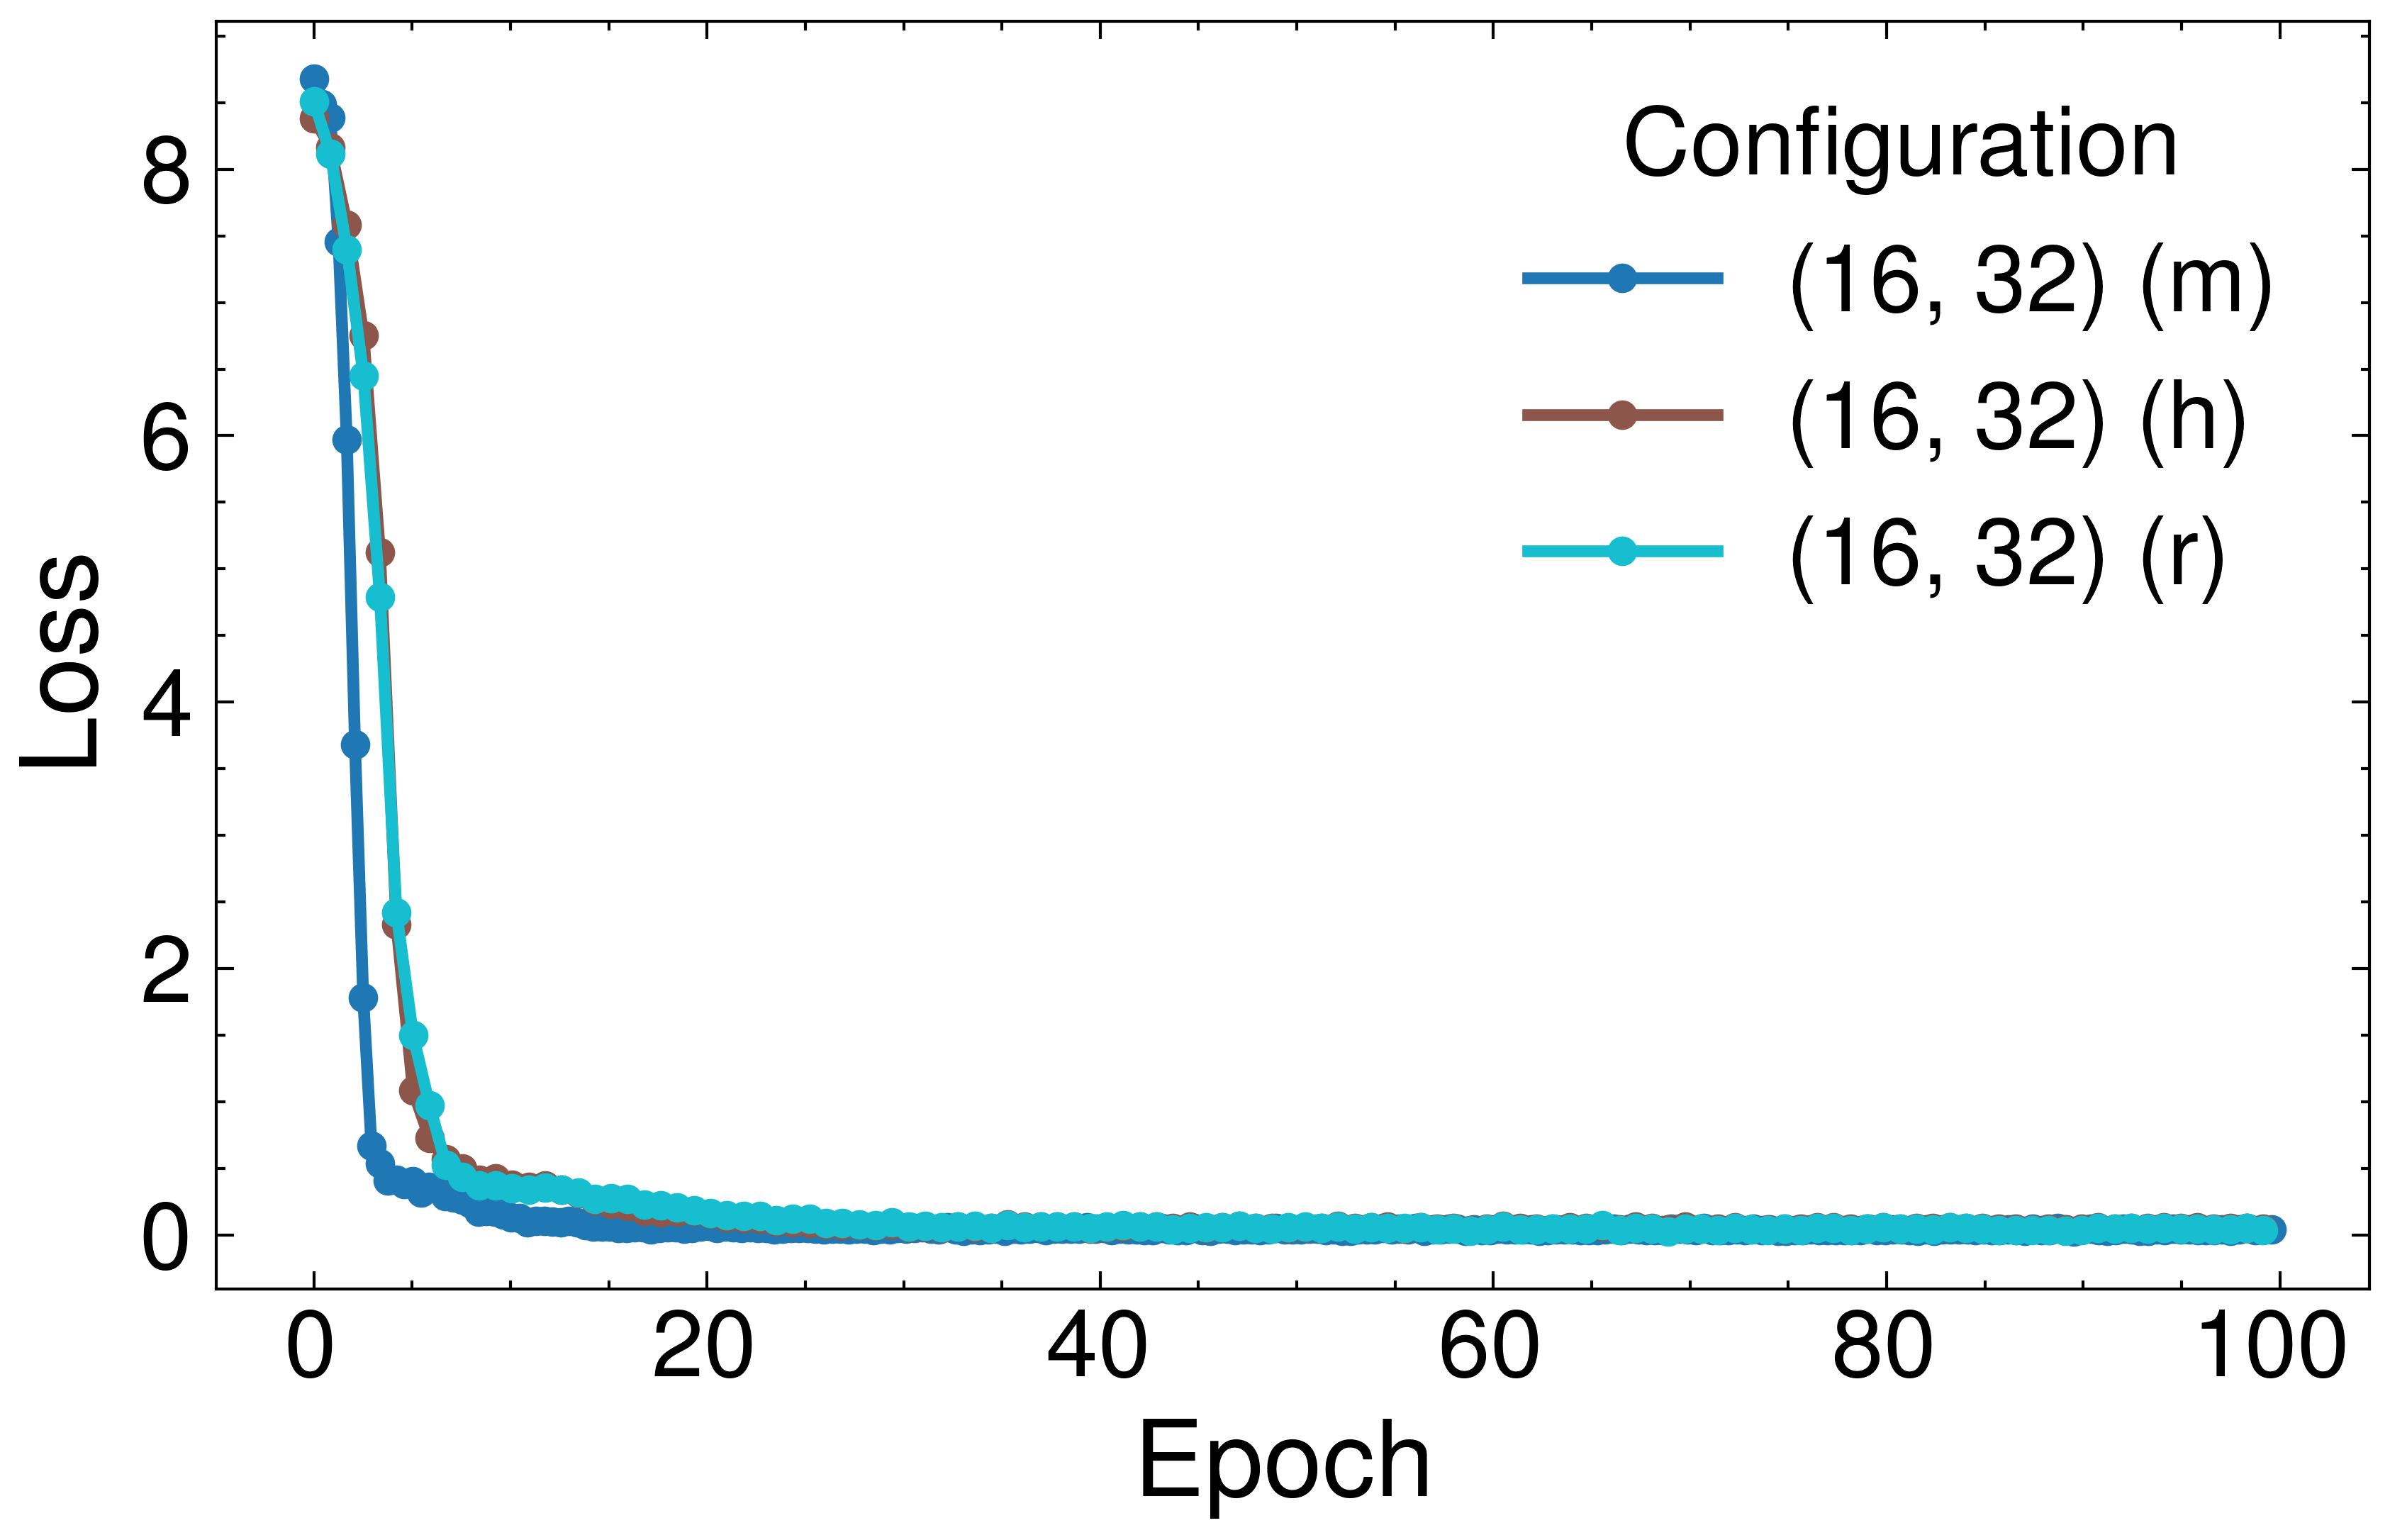

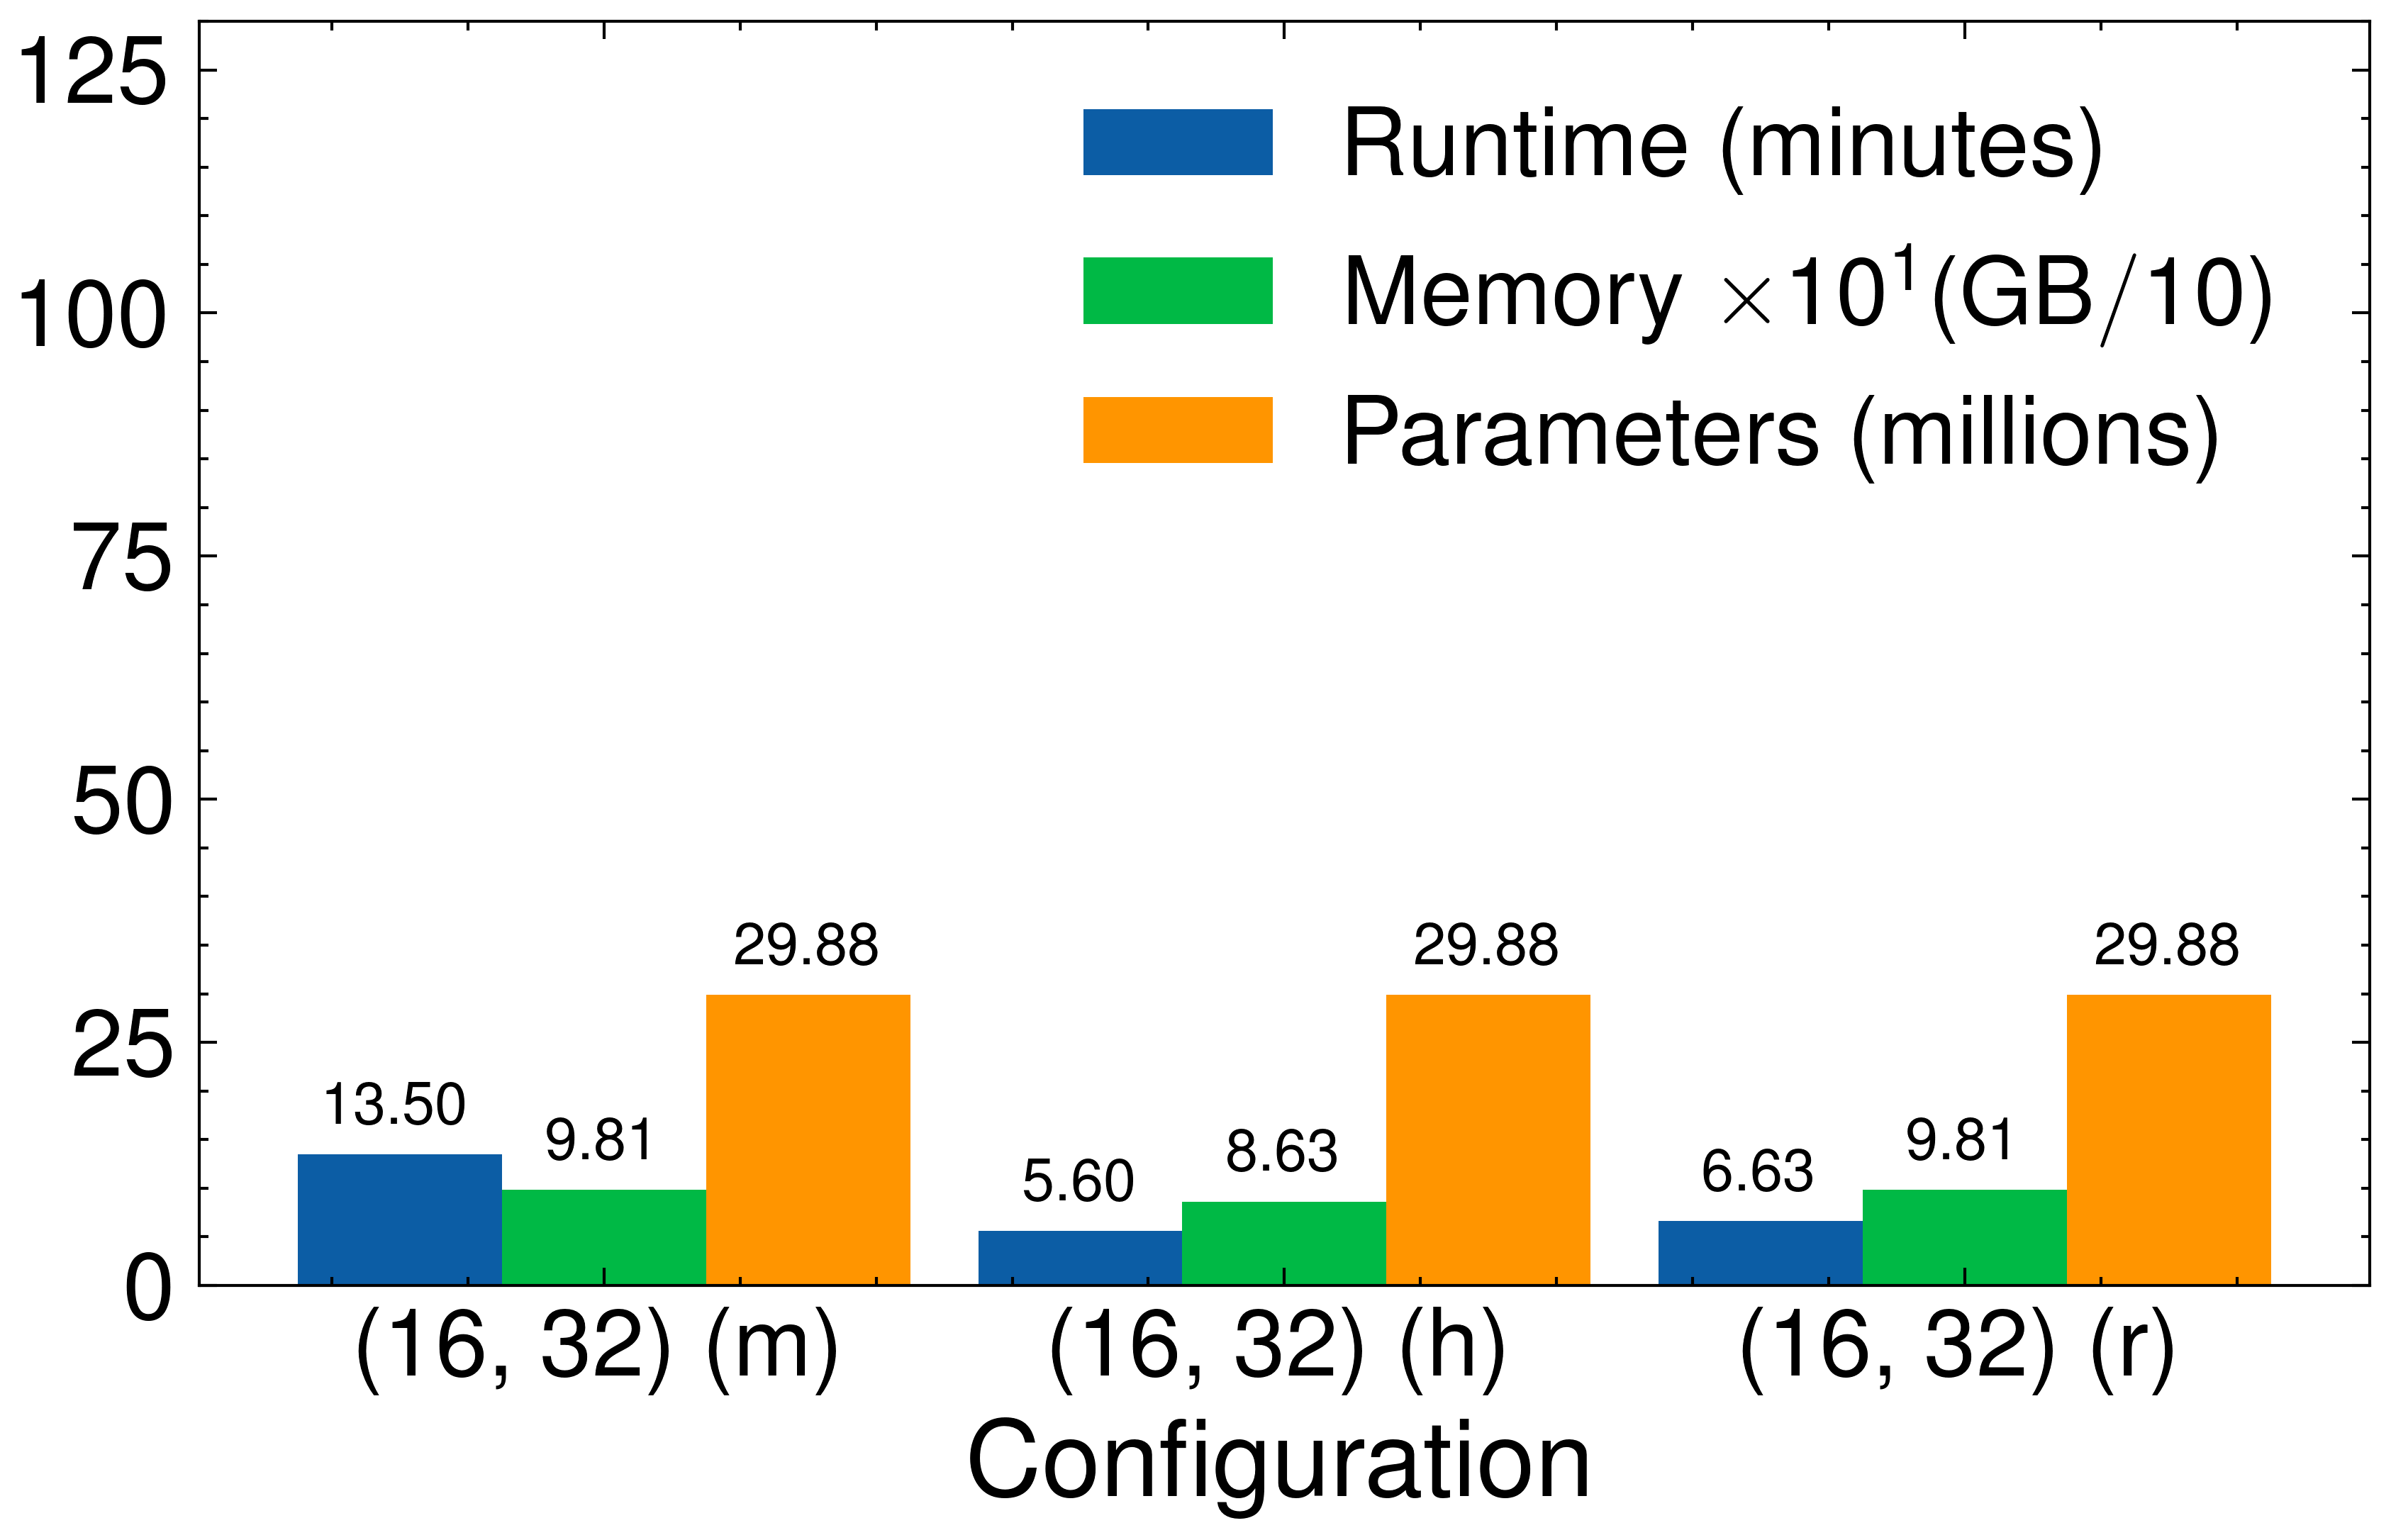

In [9]:
plot_loss_results(loss_df, figsize=FIGSIZE, filepath=PLOTS_DIR / f"{Path(FOLDER_TO_PLOT).name}_16_32_on_Datasets_loss.pdf")
plot_metrics(
    metrics_df, figsize=FIGSIZE, ylim=(0, 130), filepath=PLOTS_DIR / f"{Path(FOLDER_TO_PLOT).name}_16_32_on_Datasets_metrics.pdf"
)